# Principal Component Analysis

In [95]:
import consts
import helper
import importlib
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import sklearn, scipy, requests
import random
from sklearn.preprocessing import StandardScaler


In [96]:
FILE_PATH = consts.RAW_DATA_PATH_RYAN

In [97]:
# importlib.reload(helper)
# df = pd.read_csv(FILE_PATH + 'data.20211223_1200')
# df = df[df.columns[8:]] # cut out the test data
# helper.pca_plot(df, num_components=244)

In [98]:
# df = pd.read_csv(FILE_PATH + 'data.20200316_1200')
# df.columns
# df = df[df.columns[7:]] # cut out testing columns
# helper.pca_plot(df, num_components=50)

## Regressions with PCA

In [99]:
USER = "RYAN"
RESPONSE_NAME = consts.RESPONSE_NAME

LASSO = "LASSO"
XGBOOST = "XGBOOST"

ALPHA = 0.05 # Set significance level

TEST_START  = "20191001"
TRAIN_TEST_GAP = 31 # days

In [117]:
importlib.reload(helper)
data = helper.Data(train_data_path=FILE_PATH)

train_df = data.update_and_get_train_df(TEST_START, backward_dayCount = 31, train_data_count=182)
response_cols = train_df.columns[:7]

# 6 months

# cut out response columns
validation_data = data.train_df[RESPONSE_NAME]

#get the transformed training data

# removing high variance features
removable_features = []

highCorr_features_map = data.find_high_corr(.6)

for _, highCorr_pairs in highCorr_features_map.items():
    for (feature1, feature2) in highCorr_pairs:
        insig_features = helper.hypothesis_test_features(data.train_df, feature1, feature2, alpha = .01)
        removable_features.extend(insig_features)

data.train_df.drop(removable_features, axis = consts.COL, inplace=True)

# cut out response columns
for col in data.train_df.columns:
    if col in response_cols:
        data.train_df.drop([col], axis = consts.COL, inplace=True)

train_df = data.train_df
print(train_df.shape)
test_dfs = data.update_and_get_test_df(data_path = FILE_PATH, start_date=TEST_START, end_date="20200301")
important_cols = train_df.columns
test_xs = [df[important_cols] for df in test_dfs]


No YYYYMMDD datetime matched.

Getting files from 2019-03-02 00:00:00 to 2019-08-31 00:00:00, inclusive.
Filtered File Dates: ['data.20190304_1200', 'data.20190305_1200', 'data.20190306_1200', 'data.20190307_1200', 'data.20190308_1200', 'data.20190311_1200', 'data.20190312_1200', 'data.20190313_1200', 'data.20190314_1200', 'data.20190315_1200', 'data.20190318_1200', 'data.20190319_1200', 'data.20190320_1200', 'data.20190321_1200', 'data.20190322_1200', 'data.20190325_1200', 'data.20190326_1200', 'data.20190327_1200', 'data.20190328_1200', 'data.20190329_1200', 'data.20190401_1200', 'data.20190402_1200', 'data.20190403_1200', 'data.20190404_1200', 'data.20190405_1200', 'data.20190408_1200', 'data.20190409_1200', 'data.20190410_1200', 'data.20190411_1200', 'data.20190412_1200', 'data.20190415_1200', 'data.20190416_1200', 'data.20190417_1200', 'data.20190418_1200', 'data.20190422_1200', 'data.20190423_1200', 'data.20190424_1200', 'data.20190425_1200', 'data.20190426_1200', 'data.20190429_

In [125]:
# Fit PCA

# # Scale the data
scalar = StandardScaler()
train_df = scalar.fit_transform(train_df) 

pca = sklearn.decomposition.PCA(n_components=40)
pca.fit(train_df)

# Fit Transform X training data
train_df_pca = pd.DataFrame(pca.transform(train_df))
# add on the original y values 
train_df_pca[RESPONSE_NAME] = validation_data.values # leave untransformed

scaled_test = [pd.DataFrame(scalar.fit_transform(df)) for df in test_xs]
transformed_test = [pd.DataFrame(pca.transform(df)) for df in scaled_test]
test_dfs_pca = []
for pca_df, df in zip(transformed_test, test_dfs):
    pca_df[RESPONSE_NAME] = df[RESPONSE_NAME]
    test_dfs_pca.append(pca_df)

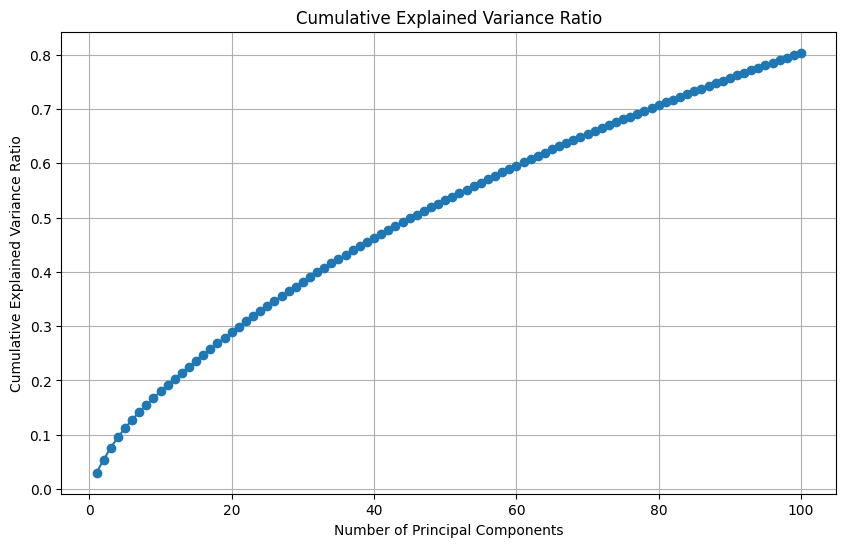

In [113]:
# # Calculate cumulative explained variance ratio
# cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# # Plot the cumulative explained variance ratio
# plt.figure(figsize=(10, 6))
# plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
# plt.title('Cumulative Explained Variance Ratio')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.grid(True)
# plt.show()

In [126]:
importlib.reload(helper)
full_ols_model = helper.Model('OLS')
full_ols_model.train(pd.DataFrame(train_df_pca))
predictions = full_ols_model.test(test_dfs_pca)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 10
response_corr: 0.06094564789591863
mean_return: 0.0004866578704385922
scale_factor: 1.5250579049278705


In [127]:
importlib.reload(helper)
lasso_model = helper.Model(LASSO)
lasso_model.train(pd.DataFrame(train_df_pca))
predictions = lasso_model.test(test_dfs_pca)

You're using: LASSO.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}
No. features being used: 10
response_corr: 0.060686124026192
mean_return: 0.000490190227423106
scale_factor: 1.5550169377082153


In [124]:
importlib.reload(helper)
xgboost_model = helper.Model(XGBOOST)
xgboost_model.train(pd.DataFrame(train_df_pca))
predictions = xgboost_model.test(test_dfs_pca)

You're using: XGBOOST.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_pa